In [1]:
#Hog classifier

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=8, 
                        pix_per_cell=8, cell_per_block=4, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
    # Return list of feature vectors
    return features



/Users/shashank/.conda/envs/gl-env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Read in car and non-car images
cars = glob.glob('OwnCollection/vehicles/**/*.png')
notcars = glob.glob('OwnCollection/non-vehicles/**/*.png')

print('len(cars)', len(cars))
print('len(notcars)', len(notcars))
    
print(cars[0:4])

('len(cars)', 3425)
('len(notcars)', 3900)
['OwnCollection/vehicles/Right/image0110.png', 'OwnCollection/vehicles/Right/image0676.png', 'OwnCollection/vehicles/Right/image0662.png', 'OwnCollection/vehicles/Right/image0104.png']


In [5]:

%matplotlib inline

imageName =['test_images/test7.png']

feat = extract_features(imageName, cspace='RGB', orient=8,pix_per_cell=8, cell_per_block=4, hog_channel='ALL')


image = mpimg.imread(imageName[0])
print(image.shape)

print('len(feat[0])',len(feat[0]))

(64, 64, 3)
('len(feat[0])', 9600)


In [72]:

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 1
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)     
print('X.shape',X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


(24.96, 'Seconds to extract HOG features...')
('X.shape', (7325, 1536))
('Using:', 8, 'orientations', 8, 'pixels per cell and', 1, 'cells per block')
('Feature vector length:', 1536)
(0.49, 'Seconds to train SVC...')


In [83]:
print(len(car_features))
#Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 15
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('Labels        ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

3425
('Test Accuracy of SVC = ', 0.957)
('SVC predicts: ', array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
        1.,  0.]))
('Labels        ', array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
        0.,  0.]))
(0.00205, 'Seconds to predict', 15, 'labels with SVC')


In [75]:
print('X_train.shape',X_train.shape)

print('X_test.shape',X_test.shape)


('X_train.shape', (5860, 1536))
('X_test.shape', (1465, 1536))


(1465, 1536)
(64, 64, 3)
('Xnew.shape', (2, 1536))
('SVC predicts: ', array([ 1.,  1.]))
(0.0005, 'Seconds to predict', 1, ' label with SVC')


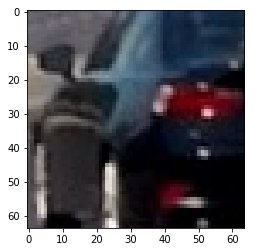

In [64]:
# Classify an image
print(X_test.shape)

#imageName =['test_images/test7.png']
#image = mpimg.imread('test_images/test7.png')
#print(image.shape)

img = mpimg.imread('test_images/test6.jpg')
img = img[420:484,810:874,:]
cv2.imwrite('test.png',img)
plt.imshow(img)
print(img.shape)

feat = extract_features(['test_images/test8.png','test_images/test8.png'], cspace='YCrCb', orient=8,pix_per_cell=8, cell_per_block=1, hog_channel='ALL')
Xnew = np.vstack((feat)).astype(np.float64)     
print('Xnew.shape',Xnew.shape)
# Fit a per-column scaler
Xnew_scaler = StandardScaler().fit(Xnew)
# Apply the scaler to X
scaled_Xnew = Xnew_scaler.transform(Xnew)
scaled_Xnew

t=time.time()
print('SVC predicts: ', svc.predict(scaled_Xnew[0:5]))
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', 1,' label with SVC')

In [76]:
import pickle

pickle.dump( svc, open( "saved_svc_YCrCb.p", "wb" ) )
pickle.dump( svc, open( "saved_X_scaler_YCrCb.p", "wb" ) )

In [77]:

loaded_svc = pickle.load( open( "saved_svc_YCrCb.p", "rb" ) )
loaded_X_scale = pickle.load( open( "saved_X_scaler_YCrCb.p", "rb" ) )

In [78]:
print(loaded_svc)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [79]:
print('Test Accuracy of original SVC = ', round(svc.score(X_test, y_test), 4))
print('Test Accuracy of pickled SVC = ', round(loaded_svc.score(X_test, y_test), 4))

print('Origin SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('Loaded SVC predicts: ', loaded_svc.predict(X_test[0:n_predict]))

('Test Accuracy of original SVC = ', 0.957)
('Test Accuracy of pickled SVC = ', 0.957)
('Origin SVC predicts: ', array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
        1.,  0.]))
('Loaded SVC predicts: ', array([ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
        1.,  0.]))
